In [16]:

import numpy as np # linear algebra
import pandas as pd # data processing

# Input data files located in "input/" directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

input\cryptocurrencypricehistory\coin_Aave.csv
input\cryptocurrencypricehistory\coin_BinanceCoin.csv
input\cryptocurrencypricehistory\coin_Bitcoin.csv
input\cryptocurrencypricehistory\coin_Cardano.csv
input\cryptocurrencypricehistory\coin_ChainLink.csv
input\cryptocurrencypricehistory\coin_Cosmos.csv
input\cryptocurrencypricehistory\coin_CryptocomCoin.csv
input\cryptocurrencypricehistory\coin_Dogecoin.csv
input\cryptocurrencypricehistory\coin_EOS.csv
input\cryptocurrencypricehistory\coin_Ethereum.csv
input\cryptocurrencypricehistory\coin_Iota.csv
input\cryptocurrencypricehistory\coin_Litecoin.csv
input\cryptocurrencypricehistory\coin_Monero.csv
input\cryptocurrencypricehistory\coin_NEM.csv
input\cryptocurrencypricehistory\coin_Polkadot.csv
input\cryptocurrencypricehistory\coin_Solana.csv
input\cryptocurrencypricehistory\coin_Stellar.csv
input\cryptocurrencypricehistory\coin_Tether.csv
input\cryptocurrencypricehistory\coin_Tron.csv
input\cryptocurrencypricehistory\coin_Uniswap.csv
input

Lets begin by importing our Bitcoin price data.

`chosen_col` variable can be changed here to alter what recorded price to use.

In [3]:
import matplotlib.pyplot as plt

data = 'input/cryptocurrencypricehistory/coin_Bitcoin.csv'
dataset = pd.read_csv(data)
chosen_col = 'Close'

Taking a look at the first few columns.

In [4]:
print(len(dataset))
dataset.head()

2991


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


Splitting our data into training set and test set.

In [15]:
split_row = len(dataset) - int(0.2 * len(dataset))
train_data = dataset.iloc[:split_row]
test_data = dataset.iloc[split_row:]

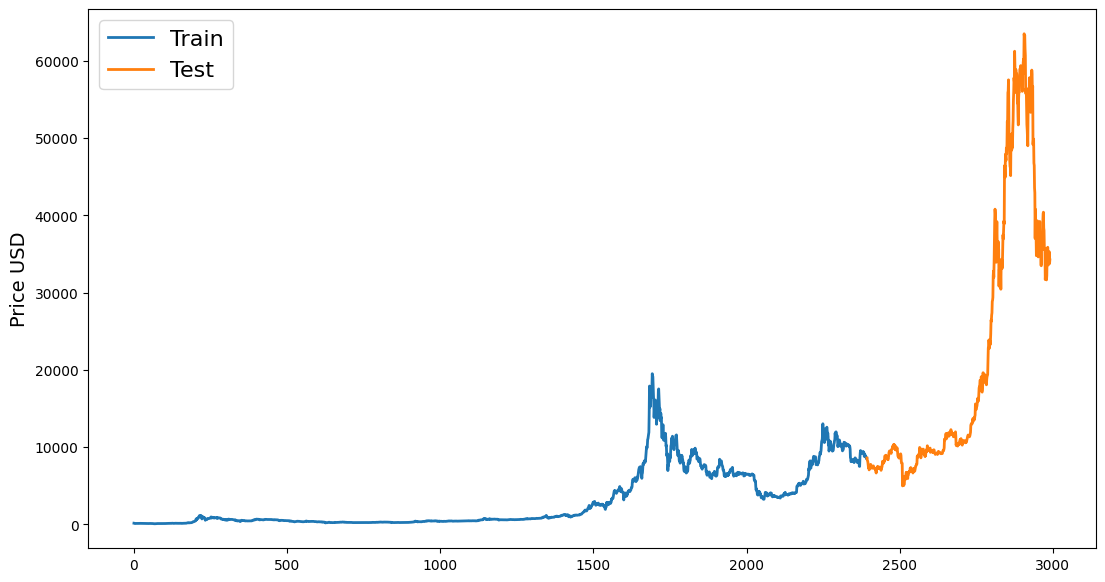

In [6]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(train_data[chosen_col], label='Train', linewidth=2)
ax.plot(test_data[chosen_col], label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

We see some pretty wild fluctuations at the end. Lets leave this as it is for now.

Continue by normalizing the values to floats between 0-1. We are using sklearn's `MinMaxScaler`. We need to be careful to fit the scaler on our entire data range or else we will end up with a messed up scale between our test data and our train data. After we fit it we then transform both our test and training data.

In [7]:
from sklearn.preprocessing import MinMaxScaler

datacol = dataset.iloc[:, 7:8].values
traincol = train_data.iloc[:, 7:8].values
testcol = test_data.iloc[:, 7:8].values

shaped_data = np.reshape(datacol, (-1,1))
train_shaped = np.reshape(traincol, (-1,1))
test_shaped = np.reshape(testcol, (-1,1))

sc = MinMaxScaler(feature_range=(0,1))
sc.fit(shaped_data)

train_scaled_data = sc.transform(train_shaped)
test_scaled_data = sc.transform(test_shaped)

Now we seperate our training data into our inputs and our outputs in time steps of `time_steps`. Where we will look at `time_steps` amount of data before we make our prediction of what the output for `y` will be.

In [8]:
X = []
y = []
time_steps = 50

for i in range(time_steps, len(train_data)):
    X.append(train_scaled_data[i-time_steps:i,0])
    y.append(train_scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

Splitting our training data into training and validation.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now we implement our actual model. We start with an LSTM input layer with 100 hidden units. We add a dropout of 0.2 before our Dense output layer with a linear activation and a shape of 1 (as we are outputting our expected price). We are using mean squared error to calculate our loss and adam as our optimizer.

In [10]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation

model = Sequential()
model.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', loss='mse')

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fit our model now on our `X` and `y` training/validation data. We take advantage of keras' early stopping class so that once we are no longer recieving improvements the model will take its best weights and stop.

In [11]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=1, callbacks=[callback], shuffle=True)

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0012 - val_loss: 7.9970e-05
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.1249e-04 - val_loss: 6.6417e-05
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.6656e-05 - val_loss: 6.3715e-05
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.5055e-05 - val_loss: 6.5257e-05
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.3780e-05 - val_loss: 6.0482e-05
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.2332e-05 - val_loss: 4.9969e-05
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.7270e-05 - val_loss: 5.5348e-05
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.0675e-05 - val_loss: 5.5086e-05
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.3631e-05 - val_loss: 5.7104e-05
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.7631e-05 - val_loss: 5.8770e-05
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,705 (479.32 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 81,804 (319.55 KB)

Now we are breaking our testing data up into time steps and splitting it again into our inputs and our expected outputs. 

We then predict on the inputs and then scale both the inputs and outputs back up, now were ready to see how we did!

In [13]:
from keras.metrics import mean_absolute_error

X_testing = []
y_testing = []

for i in range(time_steps, len(test_data)):
    X_testing.append(test_scaled_data[i-time_steps:i,0])
    y_testing.append(test_scaled_data[i, 0])

X_testing, y_testing = np.array(X_testing), np.array(y_testing)
X_testing = np.reshape(X_testing, (X_testing.shape[0], X_testing.shape[1], 1))

predicted_price = model.predict(X_testing)
inv_price = sc.inverse_transform(predicted_price)
real_price = np.reshape(y_testing, (-1,1))
real_price = sc.inverse_transform(real_price)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


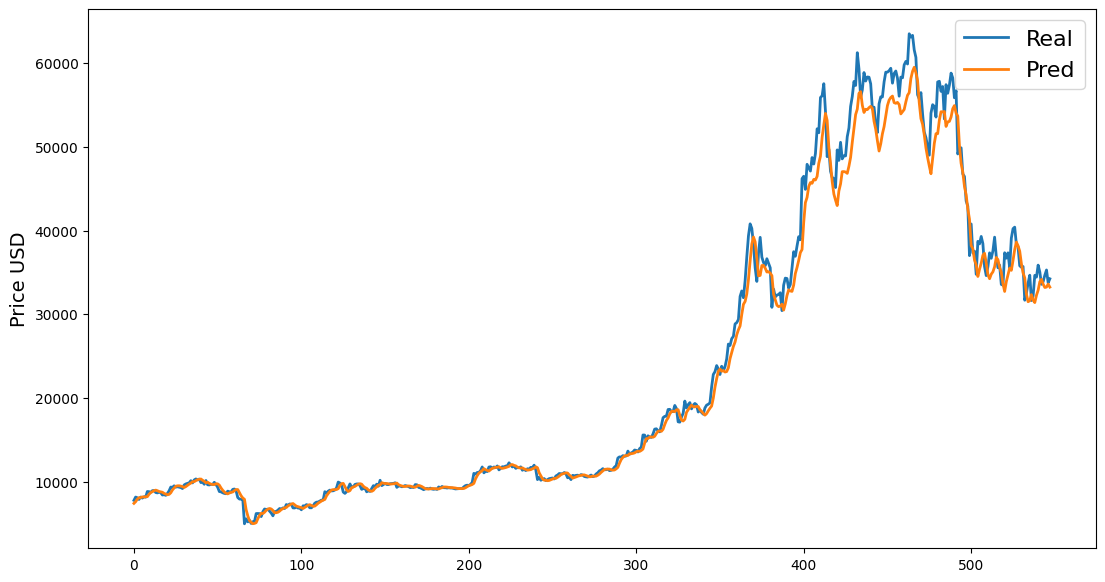

In [14]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(real_price, label='Real', linewidth=2)
ax.plot(inv_price, label='Pred', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

It looks ok! 

You can see that the price climbed from 10k USD all the way up to 60k and back down to 35k. The largest problem I see with the predictions is that on the larger changes it lags a bit behind the actual prices. I assume this comes from the model still being innacurate when it comes to outrageous volatilitys like here.